In [ ]:
#!pip install tensorflow

In [ ]:
#!pip install yfinance

### Dependencies

In [ ]:
#importing needed libraries

import os
import nltk
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import nltk


from pyspark.sql.functions import col, to_timestamp, to_date
from pyspark.sql.functions import from_unixtime, unix_timestamp
from pyspark.sql.functions import udf, lag,lit, expr
from pyspark.sql.functions import date_format
from pyspark.sql.functions import concat, when
from pyspark.sql.functions import collect_list, size

from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType,StringType
import pyspark.sql as sql_f
from pyspark.sql import Row

from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, GRU, Dropout
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
from keras.layers import Dense
from keras.optimizers import Adam

2024-05-06 17:40:25.551178: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 17:40:25.568865: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 17:40:26.533795: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 17:40:28.369383: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 17:40:32.068550: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
!wget https://zenodo.org/records/2686862/files/tweets.csv.zip?download=1
!unzip tweets.csv.zip?download=1
!hadoop fs -put tweets.csv /

In [ ]:
path = "hdfs://st446-cluster-w10-m.europe-west2-c.c.st446-414812.internal.:8020/tweets.csv"
tweets = spark.read.csv(path, header = True, multiLine = True, ignoreLeadingWhiteSpace = True, ignoreTrailingWhiteSpace = True)

In [ ]:
tweets = tweets.filter(~F.col('created_at').contains('"<a href="'))
tweets.filter(F.col('created_at').contains('"<a href="')).count()
tweets = tweets.select("text", "created_at")
tweets.show(10)

+--------------------+--------------------+
|                text|          created_at|
+--------------------+--------------------+
|RT @cruzfloresiv:...|Thu May 18 22:00:...|
|Investors Eye Fed...|Thu May 18 22:00:...|
|Sell $NLNK (Ne❑wL...|Thu May 18 22:00:...|
|Increase: $VCO $N...|Thu May 18 22:00:...|
|Former #FDA commi...|Thu May 18 22:00:...|
|https://t.co/uy1J...|Thu May 18 22:00:...|
|https://t.co/Wgmf...|Thu May 18 22:00:...|
|RT @djdsk3000: $l...|Thu May 18 22:00:...|
|EA's Success This...|Thu May 18 22:00:...|
|The Internet Of T...|Thu May 18 22:00:...|
+--------------------+--------------------+
only showing top 10 rows



In [ ]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [ ]:
tweets = tweets.withColumn('created_at', from_unixtime(unix_timestamp('created_at', 'EEE MMM d HH:mm:ss z yyyy')).alias('Time'))
tweets.show()

+--------------------+-------------------+
|                text|         created_at|
+--------------------+-------------------+
|RT @cruzfloresiv:...|2017-05-18 22:00:00|
|Investors Eye Fed...|2017-05-18 22:00:01|
|Sell $NLNK (Ne❑wL...|2017-05-18 22:00:02|
|Increase: $VCO $N...|2017-05-18 22:00:02|
|Former #FDA commi...|2017-05-18 22:00:02|
|https://t.co/uy1J...|2017-05-18 22:00:02|
|https://t.co/Wgmf...|2017-05-18 22:00:02|
|RT @djdsk3000: $l...|2017-05-18 22:00:02|
|EA's Success This...|2017-05-18 22:00:03|
|The Internet Of T...|2017-05-18 22:00:03|
|#BioTechne $TECH ...|2017-05-18 22:00:03|
|RT @bapao83: Enou...|2017-05-18 22:00:05|
|https://t.co/0iuk...|2017-05-18 22:00:07|
|RT @AceCrypto: $L...|2017-05-18 22:00:07|
|RT @whotrades: Wh...|2017-05-18 22:00:08|
|      Popular: $GLOB|2017-05-18 22:00:10|
|RT @RaviFuture: r...|2017-05-18 22:00:10|
|Top 3 $BTC $NMC o...|2017-05-18 22:00:11|
|Why Fitbit Inc. S...|2017-05-18 22:00:12|
|RT @iFlopSets: $L...|2017-05-18 22:00:14|
+----------

In [ ]:
tweets = tweets.withColumn("Time", to_date(col("created_at")))
tweets.show()

+--------------------+-------------------+----------+
|                text|         created_at|      Time|
+--------------------+-------------------+----------+
|RT @cruzfloresiv:...|2017-05-18 22:00:00|2017-05-18|
|Investors Eye Fed...|2017-05-18 22:00:01|2017-05-18|
|Sell $NLNK (Ne❑wL...|2017-05-18 22:00:02|2017-05-18|
|Increase: $VCO $N...|2017-05-18 22:00:02|2017-05-18|
|Former #FDA commi...|2017-05-18 22:00:02|2017-05-18|
|https://t.co/uy1J...|2017-05-18 22:00:02|2017-05-18|
|https://t.co/Wgmf...|2017-05-18 22:00:02|2017-05-18|
|RT @djdsk3000: $l...|2017-05-18 22:00:02|2017-05-18|
|EA's Success This...|2017-05-18 22:00:03|2017-05-18|
|The Internet Of T...|2017-05-18 22:00:03|2017-05-18|
|#BioTechne $TECH ...|2017-05-18 22:00:03|2017-05-18|
|RT @bapao83: Enou...|2017-05-18 22:00:05|2017-05-18|
|https://t.co/0iuk...|2017-05-18 22:00:07|2017-05-18|
|RT @AceCrypto: $L...|2017-05-18 22:00:07|2017-05-18|
|RT @whotrades: Wh...|2017-05-18 22:00:08|2017-05-18|
|      Popular: $GLOB|2017-0

In [ ]:
tweets = tweets.select('text', 'Time')

In [ ]:
min_date = tweets.select(F.min(F.col('Time'))).collect()[0][0]
max_date = tweets.select(F.max(F.col('Time'))).collect()[0][0]
min_date, max_date

(datetime.date(2017, 5, 18), datetime.date(2017, 9, 12))

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

analyze_sentiment_udf = udf(analyze_sentiment, StringType())
tweets = tweets.withColumn("sentiment_score", analyze_sentiment_udf(tweets["text"]))
tweets = tweets.withColumn('sentiment', F.when(F.col("sentiment_score") >= 0.05, 'positive')
                   .when(F.col('sentiment_score') <= -0.05, 'negative')
                   .when(F.col('sentiment_score') == 0, 'neutral'))

In [ ]:
tweets_TSLA = tweets.filter(F.col('text').contains('TSLA'))

In [ ]:
tweets_TSLA = tweets_TSLA.withColumn('Stock', F.lit('TSLA'))
tweets_TSLA.show()

+--------------------+----------+---------------+---------+-----+
|                text|      Time|sentiment_score|sentiment|Stock|
+--------------------+----------+---------------+---------+-----+
|So, roughly...the...|2017-05-18|            0.0|  neutral| TSLA|
|Vivint Solar, Dai...|2017-05-18|         0.0258|  neutral| TSLA|
|Retail Is Dead Fo...|2017-05-18|        -0.4588| negative| TSLA|
|"REPORT: Tesla CE...|2017-05-18|            0.0|  neutral| TSLA|
|RT @jjjinvesting:...|2017-05-18|         0.4215| positive| TSLA|
|When Valuation Fa...|2017-05-18|        -0.4215| negative| TSLA|
|"REPORT: Tesla CE...|2017-05-18|            0.0|  neutral| TSLA|
|Trade with the be...|2017-05-18|         0.7319| positive| TSLA|
|Trade with the be...|2017-05-18|         0.7319| positive| TSLA|
|Major #workplace ...|2017-05-18|        -0.6705| negative| TSLA|
|https://t.co/RQL8...|2017-05-18|         0.8525| positive| TSLA|
|RT @jjjinvesting:...|2017-05-18|        -0.4215| negative| TSLA|
|RT @jjjin

In [ ]:
avg_sentiment_TSLA = tweets_TSLA.groupBy('Time').agg(F.avg('sentiment_score').alias('Avg_sentiment'))
avg_sentiment_TSLA.show()

+----------+--------------------+
|      Time|       Avg_sentiment|
+----------+--------------------+
|2017-08-11| 0.08888752345215763|
|2017-09-11| 0.10652564885496174|
|2017-06-29|  0.1664214659685861|
|2017-07-31|0.054267237903225796|
|2017-08-14| 0.13224024216524213|
|2017-08-18|  0.4036163607760801|
|2017-08-10| 0.08166492248062002|
|2017-06-30| 0.36907981836528236|
|2017-08-19| 0.20118461538461554|
|2017-07-06|0.040459929824561626|
|2017-05-26| 0.09072784090909095|
|2017-06-28|  0.1681983495873972|
|2017-06-14| 0.07841232279171173|
|2017-08-08|  0.0703493324856961|
|2017-08-22| 0.19314042815973592|
|2017-07-03| 0.10181283509342005|
|2017-07-30| 0.09866587301587257|
|2017-06-08|0.021654950495049466|
|2017-08-04| 0.12447025998731782|
|2017-06-01| 0.12523416181914251|
+----------+--------------------+
only showing top 20 rows



### Data Preprocessing

In [ ]:
# importing data from yahoo finance for tesla stock in 2017
stock = 'TSLA'
stock_data = yf.Ticker(stock )
stock_Df = stock_data.history(period='1d', start='2017-05-01', end='2017-09-12')
stock_Df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-05-01 00:00:00-04:00,20.992001,21.816668,20.987333,21.521999,132444000,0.0,0.0
2017-05-02 00:00:00-04:00,21.600000,21.844000,21.104000,21.259333,80742000,0.0,0.0
2017-05-03 00:00:00-04:00,21.177999,21.435333,20.696667,20.734667,107001000,0.0,0.0
2017-05-04 00:00:00-04:00,20.496000,20.518000,19.384001,19.697332,212280000,0.0,0.0
2017-05-05 00:00:00-04:00,19.866667,20.570000,19.786667,20.556667,122659500,0.0,0.0


In [ ]:
# converting df to spark df
sparkDF = spark.createDataFrame(stock_Df.reset_index())
sparkDF.show()

+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+
|               Date|              Open|              High|               Low|             Close|   Volume|Dividends|Stock Splits|
+-------------------+------------------+------------------+------------------+------------------+---------+---------+------------+
|2017-05-01 04:00:00|20.992000579833984|21.816667556762695|20.987333297729492| 21.52199935913086|132444000|      0.0|         0.0|
|2017-05-02 04:00:00|21.600000381469727|  21.8439998626709|21.104000091552734| 21.25933265686035| 80742000|      0.0|         0.0|
|2017-05-03 04:00:00| 21.17799949645996|21.435333251953125|20.696666717529297| 20.73466682434082|107001000|      0.0|         0.0|
|2017-05-04 04:00:00|20.496000289916992| 20.51799964904785|19.384000778198242| 19.69733238220215|212280000|      0.0|         0.0|
|2017-05-05 04:00:00|19.866666793823242| 20.56999969482422|19.786666870117188| 20.5

In [ ]:
# dropping unnecessary columns
sparkDF = sparkDF.drop(*["Dividends", "Stock Splits"])

In [ ]:
df = sparkDF

# scaling close price to value between 0 and 1. utilising minmax scaler
assembler = VectorAssembler(inputCols = ["Close"], outputCol = "CloseVec")
vector_df = assembler.transform(df)
scaler = MinMaxScaler(inputCol = "CloseVec", outputCol = "ScaledClosePrices")
scalerModel = scaler.fit(vector_df)
scaled_df = scalerModel.transform(vector_df)
scaled_df.select("Close", "ScaledClosePrices").show()

+------------------+--------------------+
|             Close|   ScaledClosePrices|
+------------------+--------------------+
| 21.52199935913086| [0.311058067797029]|
| 21.25933265686035|[0.26628025468594...|
| 20.73466682434082|[0.17683843205957...|
| 19.69733238220215|               [0.0]|
| 20.55666732788086|[0.1464941664276791]|
|20.479333877563477|[0.13331083273667...|
|21.417333602905273|[0.2932152897407034]|
|21.681333541870117|[0.33822038489026...|
|21.540000915527344|[0.31412686304615...|
| 21.65399932861328|[0.3335606153718093]|
|21.058666229248047|[0.23207186924682...|
|21.134000778198242|[0.24491444245667...|
|20.407333374023438|[0.12103662719957...|
| 20.87066650390625|[0.20002282574978...|
|20.722000122070312|[0.17467909011749...|
|20.690000534057617|[0.16922399604093...|
|20.257333755493164|[0.09546560952880...|
|20.681333541870117|[0.1677465002142759]|
|21.121999740600586|[0.2428685789572599]|
|21.676000595092773|  [0.33731125673636]|
+------------------+--------------

In [ ]:
# extracting the number from scaled close price vector
extract = udf(lambda x: float(x[0]), DoubleType())
scaled_df = scaled_df.withColumn("ScaledClosePrices", extract("ScaledClosePrices"))
scaled_df.select("ScaledClosePrices").show(5)

+-------------------+
|  ScaledClosePrices|
+-------------------+
|  0.311058067797029|
|0.26628025468594435|
|0.17683843205957844|
|                0.0|
| 0.1464941664276791|
+-------------------+
only showing top 5 rows



In [ ]:
scaled_df = scaled_df.withColumn('Date', date_format('Date', 'yyyy-MM-dd'))
scaled_df.show(5)

+----------+------------------+------------------+------------------+-----------------+---------+-------------------+-------------------+
|      Date|              Open|              High|               Low|            Close|   Volume|           CloseVec|  ScaledClosePrices|
+----------+------------------+------------------+------------------+-----------------+---------+-------------------+-------------------+
|2017-05-01|20.992000579833984|21.816667556762695|20.987333297729492|21.52199935913086|132444000|[21.52199935913086]|  0.311058067797029|
|2017-05-02|21.600000381469727|  21.8439998626709|21.104000091552734|21.25933265686035| 80742000|[21.25933265686035]|0.26628025468594435|
|2017-05-03| 21.17799949645996|21.435333251953125|20.696666717529297|20.73466682434082|107001000|[20.73466682434082]|0.17683843205957844|
|2017-05-04|20.496000289916992| 20.51799964904785|19.384000778198242|19.69733238220215|212280000|[19.69733238220215]|                0.0|
|2017-05-05|19.866666793823242| 20

In [ ]:
# Perform inner join on 'Date' column
merged_df = scaled_df.join(avg_sentiment_TSLA, scaled_df['Date'] == avg_sentiment_TSLA['Time'], 'inner')
merged_df.show(5)

+----------+------------------+------------------+------------------+------------------+---------+--------------------+-------------------+----------+--------------------+
|      Date|              Open|              High|               Low|             Close|   Volume|            CloseVec|  ScaledClosePrices|      Time|       Avg_sentiment|
+----------+------------------+------------------+------------------+------------------+---------+--------------------+-------------------+----------+--------------------+
|2017-08-11| 23.79800033569336|24.083999633789062| 23.57466697692871|23.857999801635742| 65487000|[23.857999801635742]| 0.7092851378356637|2017-08-11| 0.08888752345215763|
|2017-09-11| 23.42333221435547|24.247333526611328|23.333332061767578|24.246000289916992|115006500|[24.246000289916992]| 0.7754290883291486|2017-09-11| 0.10652564885496174|
|2017-06-29|24.707332611083984|24.733333587646484|23.606666564941406|24.049999237060547|123315000|[24.049999237060547]| 0.7420160274481267|2

In [ ]:
scaled_df = merged_df

#converting Avg_sentiment to an array with a single element
scaled_df = scaled_df.withColumn("Avg_sentiment_array", array("Avg_sentiment"))

In [ ]:
#creating a window of 10 days to get features
windowSpec = Window.orderBy("Date").rowsBetween(-9, 0)
scaled_df = scaled_df.withColumn("features", concat(collect_list("ScaledClosePrices").over(windowSpec), col("Avg_sentiment_array")))
scaled_df = scaled_df.withColumn("count", size("features"))
scaled_df = scaled_df.filter(col("count") == 11)

In [ ]:
#dropping count column
scaled_df = scaled_df.drop("count")

In [ ]:
#ordering by date column and removing null values
windowSpec = Window.orderBy("Date")
scaled_df = scaled_df.withColumn("label", lag(col("ScaledClosePrices"), -1).over(windowSpec))
scaled_df = scaled_df.filter(col("label").isNotNull())

In [ ]:
#repartitioning df by date
scaled_df = scaled_df.repartition("Date")

#calculating max date in 30 day period
max_date = scaled_df.agg(F.max("Date")).collect()[0][0]
threshold_date = max_date - F.expr('INTERVAL 30 DAYS')
threshold_date = F.to_date(threshold_date)

#splitting into train and test
train_df = scaled_df.filter(col("Date") <= threshold_date)
test_df = scaled_df.filter(col("Date") > threshold_date)

24/05/06 17:48:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:48:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:48:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:48:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:48:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:48:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

In [ ]:
train_df.show(5)
test_df.show(5)

24/05/06 17:49:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:49:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:49:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:49:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:49:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:49:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

+----------+------------------+------------------+------------------+------------------+---------+--------------------+-------------------+----------+-------------------+--------------------+--------------------+------------------+
|      Date|              Open|              High|               Low|             Close|   Volume|            CloseVec|  ScaledClosePrices|      Time|      Avg_sentiment| Avg_sentiment_array|            features|             label|
+----------+------------------+------------------+------------------+------------------+---------+--------------------+-------------------+----------+-------------------+--------------------+--------------------+------------------+
|2017-06-22| 25.19933319091797|25.666667938232422|24.904666900634766|25.507333755493164|112947000|[25.507333755493164]| 0.9904535040777454|2017-06-22|0.12047933844678813|[0.12047933844678...|[0.70303439404787...|0.9999999999999999|
|2017-08-02|21.262666702270508|21.808000564575195| 20.74799919128418| 21

24/05/06 17:50:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:50:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:50:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:50:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:50:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:50:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

+----------+------------------+------------------+------------------+------------------+---------+--------------------+------------------+----------+-------------------+--------------------+--------------------+------------------+
|      Date|              Open|              High|               Low|             Close|   Volume|            CloseVec| ScaledClosePrices|      Time|      Avg_sentiment| Avg_sentiment_array|            features|             label|
+----------+------------------+------------------+------------------+------------------+---------+--------------------+------------------+----------+-------------------+--------------------+--------------------+------------------+
|2017-08-18|23.527332305908203|23.600000381469727|23.053333282470703|23.163999557495117| 81123000|[23.163999557495117]|0.5909762202509271|2017-08-18| 0.4036163607760801|[0.4036163607760801]|[0.67859978656948...|0.4818730381072966|
|2017-08-10|24.106666564941406| 24.44333267211914|23.643999099731445| 23.693

In [ ]:
#x_train, y_train from train_df
x_train = train_df.select("features")
y_train = train_df.select("label")

#x_test, y_test from test_df
x_test = test_df.select("features")
y_test = test_df.select("label")

## Model Definition and Training

### 1. Baseline Model (Decision Tree Regressor)

In [ ]:
#converting array to vector
array_to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
train_df = train_df.withColumn("features", array_to_vector("features"))
test_df = test_df.withColumn("features", array_to_vector("features"))

In [ ]:
#creating a decisiom tree model
dt_model = DecisionTreeRegressor(featuresCol = "features", labelCol = "label")

In [ ]:
#noting time as metric
start_time = time.time()

In [ ]:
dt_model = dt_model.fit(train_df)

24/05/06 17:51:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:51:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:51:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:51:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:51:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:51:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

In [ ]:
end_time = time.time()

dt_training_time = end_time - start_time
print("Training time:", dt_training_time, "seconds")

Training time: 73.33275175094604 seconds


In [ ]:
#creating predictions on the train and test data
start_time = time.time()
dt_predictions_train = dt_model.transform(train_df)
dt_predictions_test = dt_model.transform(test_df)
end_time = time.time()
dt_prediction_time = end_time - start_time
print("Prediction time:", dt_prediction_time, "seconds")

#calculating mae
mae_evaluator = RegressionEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "mae")
dt_mae = mae_evaluator.evaluate(dt_predictions_test)
print("MAE on test data for Decision Tree model= %g" % dt_mae)

#calculating mse(loss)
mse_evaluator = RegressionEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "mse")
dt_loss = mse_evaluator.evaluate(dt_predictions_test)
print("Loss on test data  Decision Tree model= %g" % dt_loss)

Prediction time: 0.16225218772888184 seconds


24/05/06 17:52:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:52:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:52:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:52:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:52:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:52:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

MAE on test data for Decision Tree model= 0.150269


24/05/06 17:53:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:53:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:53:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:53:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:53:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:53:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

Loss on test data  Decision Tree model= 0.0346071


In [ ]:
def inverse_transform(predictions_df, scaler_model, scaled_col = "ScaledPrediction", original_col = "OriginalPrediction"):

    #retaining the original value from scaled value
    original_min = scaler_model.originalMin.toArray()[0]
    original_max = scaler_model.originalMax.toArray()[0]
    range_val = original_max - original_min
    inverse_expr = f"{original_min} + ({scaled_col} * {range_val})"
    restored_df = predictions_df.withColumn( original_col, expr(inverse_expr))
    return restored_df.select("Date","Close", original_col, scaled_col)

#applying function on train anad test predictions
dl_train_predictions_df = inverse_transform(dt_predictions_train, scalerModel, "prediction", "OriginalPrediction")
dl_test_predictions_df = inverse_transform(dt_predictions_test, scalerModel, "prediction", "OriginalPrediction")

In [ ]:
train_results = dl_train_predictions_df.select("Date", "Close" ,"OriginalPrediction").withColumnRenamed( "Close" , "Actual").withColumnRenamed("OriginalPrediction", "Predicted")
test_results = dl_test_predictions_df.select("Date","Close","OriginalPrediction").withColumnRenamed( "Close" , "Actual").withColumnRenamed("OriginalPrediction", "Predicted")

In [ ]:
#ordering by date
dl_train_predictions_df = dl_train_predictions_df.orderBy("Date")
dl_test_predictions_df = dl_test_predictions_df.orderBy("Date")

#converting to pandas
train_results_pd = dl_train_predictions_df.toPandas()
test_results_pd = dl_test_predictions_df.toPandas()

#formatting date
train_results_pd['Date'] = pd.to_datetime(train_results_pd['Date'])
test_results_pd['Date'] = pd.to_datetime(test_results_pd['Date'])

24/05/06 17:54:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:54:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:54:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:54:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:54:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:54:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

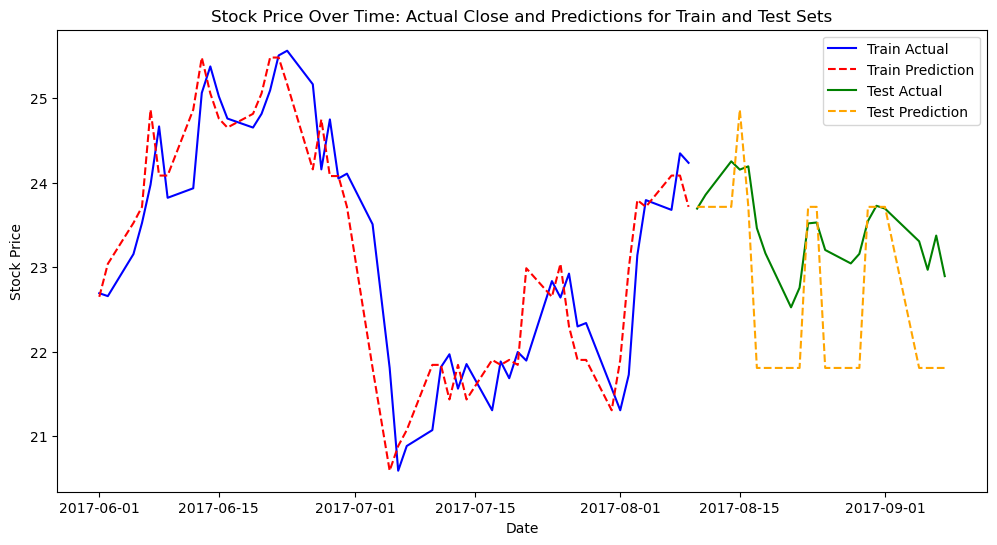

In [ ]:
#date as index
train_results_pd.set_index('Date', inplace=True)
test_results_pd.set_index('Date', inplace=True)

#plotting
plt.figure(figsize=(12, 6))
plt.plot(train_results_pd.index, train_results_pd['Close'], label='Train Actual', color='blue')
plt.plot(train_results_pd.index, train_results_pd['OriginalPrediction'], label='Train Prediction', linestyle='--', color='red')
plt.plot(test_results_pd.index, test_results_pd['Close'], label='Test Actual', color='green')
plt.plot(test_results_pd.index, test_results_pd['OriginalPrediction'], label='Test Prediction', linestyle='--', color='orange')
plt.title('Stock Price Over Time: Actual Close and Predictions for Train and Test Sets')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


### 2. LSTM Model

In [ ]:
#collecting features and labels
train_features = [row['features'] for row in train_df.select('features').collect()]
train_labels = [row['label'] for row in train_df.select('label').collect()]
test_features = [row['features'] for row in test_df.select('features').collect()]
test_labels = [row['label'] for row in test_df.select('label').collect()]

#reshaping values as needed
x_train = np.array(train_features)
y_train = np.array(train_labels).reshape(-1, 1)
x_test = np.array(test_features)
y_test = np.array(test_labels).reshape(-1, 1)

24/05/06 17:56:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:56:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:56:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:56:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:56:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 17:56:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

In [ ]:
input_shape = (x_train.shape[1], 1)

In [ ]:
#utilizing mirror strategy with strategy scope for lstm
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    LSTM_model = Sequential([
        LSTM(units=64, return_sequences=True, input_shape=input_shape),
        LSTM(units=64),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])

    LSTM_model.compile(optimizer = Adam(), loss = 'mean_squared_error', metrics = ['mae'])
LSTM_model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 11, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

### 2. CNN Model

In [ ]:
#utilizing mirror strategy with strategy scope for cnn

with strategy.scope():
    CNN_model = Sequential([
        Conv1D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters = 64, kernel_size = 3, activation = 'relu'),
        MaxPooling1D(pool_size = 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
        ])
    CNN_model.compile(optimizer = Adam(), loss = 'mean_squared_error', metrics = ['mae'])
CNN_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 9, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,561 (41.25 KB)

 Trainable params: 10,561 (41.25 KB)

 Non-trainable params: 0 (0.00 B)

### 3. GRU Model

In [ ]:
#utilizing mirror strategy with strategy scope for gru
with strategy.scope():
    GRU_model = Sequential([
        GRU(units = 64, return_sequences = True, input_shape = input_shape),
        GRU(units = 64),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    GRU_model.compile(optimizer = Adam(), loss = 'mean_squared_error', metrics = ['mae'])

GRU_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 11, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,937 (156.00 KB)

 Trainable params: 39,937 (156.00 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training and Evaluation of Neural Network Models

In [ ]:
#creating a fn for decaying learning rate
def decay(epoch):
    if epoch < 30:
        return 1e-2
    else:
        return 1e-2

class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        learning_rate = self.model.optimizer.learning_rate
        print(f"\nlearning rate for epoch {epoch + 1} is {learning_rate}")

In [ ]:
#creating checkpoint directories
lstm_checkpoint_dir = './checkpoints/lstm'
cnn_checkpoint_dir = './checkpoints/cnn'
gru_checkpoint_dir = './checkpoints/gru'

#updating the filepath name to end with '.weights.h5'
lstm_checkpoint_prefix = './checkpoints/lstm/ckpt_{epoch}.weights.h5'
cnn_checkpoint_prefix = './checkpoints/lstm/ckpt_{epoch}.weights.h5'
gru_checkpoint_prefix = './checkpoints/lstm/ckpt_{epoch}.weights.h5'

In [ ]:
#creating local and hdfs path
local_checkpoint_path = './checkpoints/lstm/ckpt_{epoch}.weights.h5'
hdfs_checkpoint_path = 'hdfs://st446-cluster-w10-m.europe-west2-c.c.st446-414812.internal.:8020/user/username/checkpoints/lstm/'

os.makedirs(os.path.dirname(local_checkpoint_path), exist_ok = True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = local_checkpoint_path,
    save_weights_only = True,
    save_best_only = False,
    monitor = 'loss',
    verbose = 1,
    mode = 'min',
)

callbacks = [
    checkpoint_callback,
]

In [ ]:
#copying filepath from local to hdfs
def copy_checkpoints_to_hdfs(local_path, hdfs_path):
    if os.path.exists(local_path):
        with hdfs.open(hdfs_path, 'w') as dest:
            with open(local_path, 'rb') as src:
                dest.write(src.read())
        print(f"Copied {local_path} to {hdfs_path}")
    else:
        print(f"Local checkpoint {local_path} does not exist.")

In [ ]:
#callbacks

lstm_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs/lstm'),
    tf.keras.callbacks.ModelCheckpoint(filepath=lstm_checkpoint_prefix, save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

cnn_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs/cnn'),
    tf.keras.callbacks.ModelCheckpoint(filepath=cnn_checkpoint_prefix, save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

gru_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs/gru'),
    tf.keras.callbacks.ModelCheckpoint(filepath=gru_checkpoint_prefix, save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [ ]:
#initialising values
EPOCHS = 50
batch_size = 32

### 1. LSTM

In [ ]:
start_time = time.time()

In [ ]:
#training lstm model
history1 = LSTM_model.fit(x_train, y_train, batch_size = batch_size , epochs = EPOCHS, callbacks = lstm_callbacks)

Epoch 1/50


2024-05-06 18:00:30.657289: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - loss: 0.3788 - mae: 0.5752
learning rate for epoch 1 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.3315 - mae: 0.5237 - learning_rate: 0.0100
Epoch 2/50


2024-05-06 18:00:34.546940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - loss: 0.2113 - mae: 0.4131
learning rate for epoch 2 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.2070 - mae: 0.4074 - learning_rate: 0.0100
Epoch 3/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0751 - mae: 0.2253
learning rate for epoch 3 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0724 - mae: 0.2246 - learning_rate: 0.0100
Epoch 4/50


2024-05-06 18:00:35.202883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:35.341308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1092 - mae: 0.2710
learning rate for epoch 4 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1060 - mae: 0.2661 - learning_rate: 0.0100
Epoch 5/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0852 - mae: 0.2295
learning rate for epoch 5 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0818 - mae: 0.2293 - learning_rate: 0.0100
Epoch 6/50


2024-05-06 18:00:35.474217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:35.612807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0498 - mae: 0.1876
learning rate for epoch 6 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0516 - mae: 0.1907 - learning_rate: 0.0100
Epoch 7/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0807 - mae: 0.2237
learning rate for epoch 7 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0811 - mae: 0.2310 - learning_rate: 0.0100
Epoch 8/50


2024-05-06 18:00:35.751362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:35.887748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0621 - mae: 0.2096
learning rate for epoch 8 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0690 - mae: 0.2151 - learning_rate: 0.0100
Epoch 9/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0466 - mae: 0.1779
learning rate for epoch 9 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0481 - mae: 0.1788 - learning_rate: 0.0100
Epoch 10/50


2024-05-06 18:00:36.017983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:36.160836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0751 - mae: 0.2443
learning rate for epoch 10 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0749 - mae: 0.2354 - learning_rate: 0.0100
Epoch 11/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0697 - mae: 0.1945
learning rate for epoch 11 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0691 - mae: 0.2017 - learning_rate: 0.0100
Epoch 12/50


2024-05-06 18:00:36.289647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:36.423319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0593 - mae: 0.1961
learning rate for epoch 12 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0692 - mae: 0.2127 - learning_rate: 0.0100
Epoch 13/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0394 - mae: 0.1607
learning rate for epoch 13 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0404 - mae: 0.1587 - learning_rate: 0.0100
Epoch 14/50


2024-05-06 18:00:36.560520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:36.694480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0454 - mae: 0.1714
learning rate for epoch 14 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0502 - mae: 0.1788 - learning_rate: 0.0100
Epoch 15/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0547 - mae: 0.1949
learning rate for epoch 15 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0540 - mae: 0.1909 - learning_rate: 0.0100
Epoch 16/50


2024-05-06 18:00:36.832959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:36.968301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0564 - mae: 0.1995
learning rate for epoch 16 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0555 - mae: 0.1916 - learning_rate: 0.0100
Epoch 17/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0384 - mae: 0.1331
learning rate for epoch 17 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0372 - mae: 0.1369 - learning_rate: 0.0100
Epoch 18/50


2024-05-06 18:00:37.108912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:37.262953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0455 - mae: 0.1736
learning rate for epoch 18 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0472 - mae: 0.1755 - learning_rate: 0.0100
Epoch 19/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0369 - mae: 0.1579
learning rate for epoch 19 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0391 - mae: 0.1582 - learning_rate: 0.0100
Epoch 20/50


2024-05-06 18:00:37.404664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:37.540676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0410 - mae: 0.1560
learning rate for epoch 20 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0442 - mae: 0.1592 - learning_rate: 0.0100
Epoch 21/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0381 - mae: 0.1561
learning rate for epoch 21 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0380 - mae: 0.1583 - learning_rate: 0.0100
Epoch 22/50


2024-05-06 18:00:37.684399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:37.822704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0381 - mae: 0.1552
learning rate for epoch 22 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0428 - mae: 0.1614 - learning_rate: 0.0100
Epoch 23/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0326 - mae: 0.1446
learning rate for epoch 23 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0350 - mae: 0.1470 - learning_rate: 0.0100
Epoch 24/50


2024-05-06 18:00:37.959282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:38.092960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0493 - mae: 0.1710
learning rate for epoch 24 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0448 - mae: 0.1641 - learning_rate: 0.0100
Epoch 25/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0315 - mae: 0.1422
learning rate for epoch 25 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0316 - mae: 0.1446 - learning_rate: 0.0100
Epoch 26/50


2024-05-06 18:00:38.239211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:38.370396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0592 - mae: 0.1847
learning rate for epoch 26 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0537 - mae: 0.1775 - learning_rate: 0.0100
Epoch 27/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0378 - mae: 0.1525
learning rate for epoch 27 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0332 - mae: 0.1421 - learning_rate: 0.0100
Epoch 28/50


2024-05-06 18:00:38.515432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:38.647855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0359 - mae: 0.1506
learning rate for epoch 28 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0408 - mae: 0.1613 - learning_rate: 0.0100
Epoch 29/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0207 - mae: 0.1153
learning rate for epoch 29 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0212 - mae: 0.1144 - learning_rate: 0.0100
Epoch 30/50


2024-05-06 18:00:38.792135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:38.924327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0510 - mae: 0.1858
learning rate for epoch 30 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0489 - mae: 0.1798 - learning_rate: 0.0100
Epoch 31/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0364 - mae: 0.1560
learning rate for epoch 31 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0379 - mae: 0.1541 - learning_rate: 0.0100
Epoch 32/50


2024-05-06 18:00:39.057297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:39.192517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0365 - mae: 0.1598
learning rate for epoch 32 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0395 - mae: 0.1617 - learning_rate: 0.0100
Epoch 33/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0222 - mae: 0.1177
learning rate for epoch 33 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0251 - mae: 0.1265 - learning_rate: 0.0100
Epoch 34/50


2024-05-06 18:00:39.333238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:39.464792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0417 - mae: 0.1547
learning rate for epoch 34 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0444 - mae: 0.1633 - learning_rate: 0.0100
Epoch 35/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0464 - mae: 0.1835
learning rate for epoch 35 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0423 - mae: 0.1736 - learning_rate: 0.0100
Epoch 36/50


2024-05-06 18:00:39.608896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:39.753624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0196 - mae: 0.1181
learning rate for epoch 36 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0264 - mae: 0.1330 - learning_rate: 0.0100
Epoch 37/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0255 - mae: 0.1324
learning rate for epoch 37 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0285 - mae: 0.1389 - learning_rate: 0.0100
Epoch 38/50


2024-05-06 18:00:39.897450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:40.033071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0416 - mae: 0.1509
learning rate for epoch 38 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0395 - mae: 0.1469 - learning_rate: 0.0100
Epoch 39/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0301 - mae: 0.1407
learning rate for epoch 39 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0308 - mae: 0.1408 - learning_rate: 0.0100
Epoch 40/50


2024-05-06 18:00:40.164145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:40.300073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0383 - mae: 0.1582
learning rate for epoch 40 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0361 - mae: 0.1547 - learning_rate: 0.0100
Epoch 41/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0338 - mae: 0.1486
learning rate for epoch 41 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0314 - mae: 0.1418 - learning_rate: 0.0100
Epoch 42/50


2024-05-06 18:00:40.442301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:40.578908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0331 - mae: 0.1378
learning rate for epoch 42 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0288 - mae: 0.1272 - learning_rate: 0.0100
Epoch 43/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0236 - mae: 0.1241
learning rate for epoch 43 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0280 - mae: 0.1339 - learning_rate: 0.0100
Epoch 44/50


2024-05-06 18:00:40.731991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:40.879199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0276 - mae: 0.1375
learning rate for epoch 44 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0313 - mae: 0.1428 - learning_rate: 0.0100
Epoch 45/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0267 - mae: 0.1284
learning rate for epoch 45 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0278 - mae: 0.1334 - learning_rate: 0.0100
Epoch 46/50


2024-05-06 18:00:41.026525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:41.168921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0283 - mae: 0.1314
learning rate for epoch 46 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0305 - mae: 0.1314 - learning_rate: 0.0100
Epoch 47/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0416 - mae: 0.1604
learning rate for epoch 47 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0345 - mae: 0.1421 - learning_rate: 0.0100
Epoch 48/50


2024-05-06 18:00:41.313363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:41.454632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0273 - mae: 0.1260
learning rate for epoch 48 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0250 - mae: 0.1222 - learning_rate: 0.0100
Epoch 49/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0338 - mae: 0.1460
learning rate for epoch 49 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0299 - mae: 0.1368 - learning_rate: 0.0100
Epoch 50/50


2024-05-06 18:00:41.590283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:00:41.738558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0400 - mae: 0.1481
learning rate for epoch 50 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0361 - mae: 0.1438 - learning_rate: 0.0100


2024-05-06 18:00:41.886612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


In [ ]:
end_time = time.time()

LSTM_training_time = end_time - start_time
print("Training time:", LSTM_training_time, "seconds")

Training time: 11.695804119110107 seconds


In [ ]:
#evaluating model
LSTM_loss, LSTM_mae = LSTM_model.evaluate(x_test, y_test)
print('Eval loss: {}, Eval mean absolute error: {}'.format(LSTM_loss, LSTM_mae))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 0.0106 - mae: 0.0780
Eval loss: 0.010592230595648289, Eval mean absolute error: 0.07801785320043564


2024-05-06 18:00:42.449943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


In [ ]:
#lstm predictions
start_time = time.time()
LSTM_train_predictions= LSTM_model.predict(x_train)
LSTM_test_predictions = LSTM_model.predict(x_test)
end_time = time.time()
LSTM_prediction_time = end_time - start_time
print("Prediction time:", LSTM_prediction_time,"seconds")

train_data = list(zip(LSTM_train_predictions, train_df.select("Date").collect()))
test_data = list(zip(LSTM_test_predictions, test_df.select("Date").collect()))

#converting to spark df
LSTM_train_predictions_df = spark.createDataFrame([
    (float(pred[0]), date['Date']) for pred, date in train_data
], ["ScaledPrediction", "Date"])
LSTM_test_predictions_df = spark.createDataFrame([
    (float(pred[0]), date['Date']) for pred, date in test_data
], ["ScaledPrediction", "Date"])

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step

2024-05-06 18:00:43.098909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Prediction time: 1.0257866382598877 seconds


2024-05-06 18:00:43.489157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
24/05/06 18:00:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:00:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:00:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:00:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:00:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause seri

In [ ]:
LSTM_train_predictions_df.show(5)
LSTM_test_predictions_df.show(5)

+-------------------+----------+
|   ScaledPrediction|      Date|
+-------------------+----------+
|  0.887464702129364|2017-06-22|
|0.35707756876945496|2017-08-02|
| 0.7457675933837891|2017-06-07|
| 0.7030913233757019|2017-08-07|
| 0.7324184775352478|2017-06-29|
+-------------------+----------+
only showing top 5 rows

+-------------------+----------+
|   ScaledPrediction|      Date|
+-------------------+----------+
| 0.7074925899505615|2017-08-18|
| 0.8429270386695862|2017-08-10|
| 0.6348764300346375|2017-09-06|
| 0.6715725660324097|2017-08-31|
|0.47742611169815063|2017-08-22|
+-------------------+----------+
only showing top 5 rows



In [ ]:
def inverse_transform_scaled_predictions(predictions_df, scaler_model, scaled_col = "ScaledPrediction", original_col = "OriginalPrediction"):
    original_min = scaler_model.originalMin.toArray()[0]
    original_max = scaler_model.originalMax.toArray()[0]
    range_val = original_max - original_min
    restored_df = predictions_df.withColumn(
        original_col,
        expr(f"{original_min} + {range_val} * {scaled_col}")
    )
    return restored_df.select(predictions_df["Date"], original_col, scaled_col)


LSTM_train_predictions_df = inverse_transform_scaled_predictions(LSTM_train_predictions_df, scalerModel)
LSTM_test_predictions_df = inverse_transform_scaled_predictions(LSTM_test_predictions_df, scalerModel)
LSTM_train_predictions_df.show()
LSTM_test_predictions_df.show()

+----------+------------------+-------------------+
|      Date|OriginalPrediction|   ScaledPrediction|
+----------+------------------+-------------------+
|2017-06-22|24.903201326974113|  0.887464702129364|
|2017-08-02|21.791949803798047|0.35707756876945496|
|2017-06-07|24.072005927075224| 0.7457675933837891|
|2017-08-07| 23.82166687901986| 0.7030913233757019|
|2017-06-29|23.993699998434522| 0.7324184775352478|
|2017-06-19|24.909802897062946| 0.8885900974273682|
|2017-08-03|22.194652397214668|0.42572784423828125|
|2017-07-06|21.255234743188566| 0.2655816674232483|
|2017-06-23|25.211961175993565| 0.9401001930236816|
|2017-06-28|24.472137436034018| 0.8139795660972595|
|2017-06-12| 24.35599931162392| 0.7941810488700867|
|2017-06-30|24.032840900143356| 0.7390909790992737|
|2017-06-26|25.250190913481674| 0.9466173648834229|
|2017-08-04|23.152848915066897| 0.5890753269195557|
|2017-08-08|24.493355045232192| 0.8175966143608093|
|2017-07-14| 22.32459923986471| 0.4478803873062134|
|2017-06-06|

In [ ]:
#creating new dataframe with prediction
def create_prediction_dataframe(scaled_df, predictions_df, scaler_model):
    original_predictions_df = inverse_transform_scaled_predictions(predictions_df, scaler_model)
    merged_df = scaled_df.join(original_predictions_df, on="Date", how="inner")
    result_df = merged_df.select("Date", "Close", "OriginalPrediction")
    return result_df

#training data
LSTM_train_result_df = create_prediction_dataframe(scaled_df, LSTM_train_predictions_df, scalerModel)
LSTM_train_result_df.show()

#testing data
LSTM_test_result_df = create_prediction_dataframe(scaled_df, LSTM_test_predictions_df, scalerModel)
LSTM_test_result_df.show()

24/05/06 18:02:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:02:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:02:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:02:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:02:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:02:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

+----------+------------------+------------------+
|      Date|             Close|OriginalPrediction|
+----------+------------------+------------------+
|2017-06-22|25.507333755493164|24.903201326974113|
|2017-08-02| 21.72599983215332|21.791949803798047|
|2017-06-07|23.976667404174805|24.072005927075224|
|2017-08-07| 23.67799949645996| 23.82166687901986|
|2017-06-29|24.049999237060547|23.993699998434522|
|2017-06-19| 24.65333366394043|24.909802897062946|
|2017-08-03|23.139333724975586|22.194652397214668|
|2017-07-06|20.588666915893555|21.255234743188566|
|2017-06-23| 25.56333351135254|25.211961175993565|
|2017-06-28|24.749332427978516|24.472137436034018|
|2017-06-12| 23.93400001525879| 24.35599931162392|
|2017-06-30|24.107332229614258|24.032840900143356|
|2017-06-26|25.166000366210938|25.250190913481674|
|2017-08-04| 23.79400062561035|23.152848915066897|
|2017-08-08|24.347999572753906|24.493355045232192|
|2017-07-14|21.851999282836914| 22.32459923986471|
|2017-06-06|23.523332595825195|

24/05/06 18:03:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:03:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:03:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:03:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:03:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:03:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

+----------+------------------+------------------+
|      Date|             Close|OriginalPrediction|
+----------+------------------+------------------+
|2017-08-18|23.163999557495117|23.847484713717677|
|2017-08-10| 23.69333267211914|24.641943342829336|
|2017-09-06|22.968666076660156|  23.4215182376563|
|2017-08-31|23.726667404174805| 23.63677781285469|
|2017-08-22| 22.75666618347168| 22.49791449250938|
|2017-09-01| 23.69333267211914|23.782382274895554|
|2017-08-14|24.253332138061523| 24.28249919734003|
|2017-08-23| 23.51799964904785|22.642056756249758|
|2017-08-16|24.194000244140625| 24.12770826993642|
|2017-08-25|23.203332901000977|23.189324853732614|
|2017-08-15|24.155332565307617|  24.0538333405932|
|2017-09-08|22.893333435058594|23.015954707464516|
|2017-09-05|23.305999755859375|23.712794642434346|
|2017-08-29|23.157333374023438|23.344351788752874|
|2017-08-17|23.461332321166992|23.734465036615575|
|2017-08-30|23.545333862304688|23.549398702507233|
|2017-08-28| 23.04400062561035|

In [ ]:
#ordering by date
LSTM_train_result_df = LSTM_train_result_df.orderBy("Date")
LSTM_test_result_df = LSTM_test_result_df.orderBy("Date")

In [ ]:
#extracting needed values
train_data = LSTM_train_result_df.select("Date", "Close", "OriginalPrediction").collect()
train_dates = [row["Date"] for row in train_data]
train_close = [row["Close"] for row in train_data]
LSTM_train_predictions = [row["OriginalPrediction"] for row in train_data]

test_data = LSTM_test_result_df.select("Date", "Close", "OriginalPrediction").collect()
test_dates = [row["Date"] for row in test_data]
test_close = [row["Close"] for row in test_data]
LSTM_test_predictions = [row["OriginalPrediction"] for row in test_data]

24/05/06 18:04:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:04:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:04:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:04:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:04:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:04:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

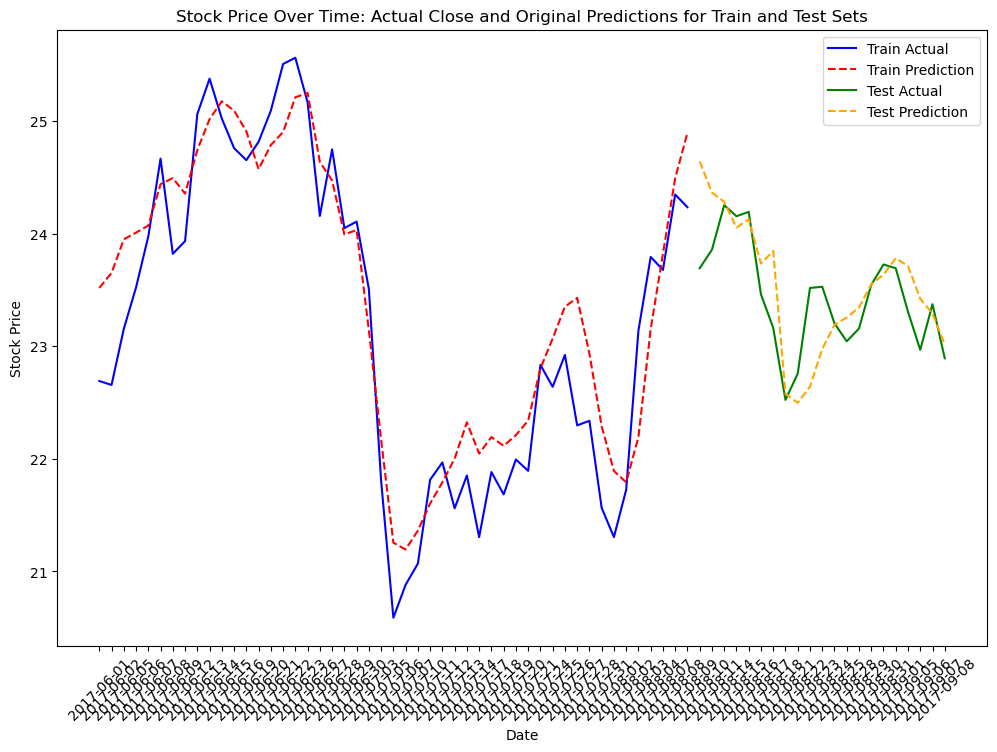

In [ ]:
#plotting
plt.figure(figsize=(12, 8))

plt.plot(train_dates, train_close, label='Train Actual', color='blue')
plt.plot(train_dates, LSTM_train_predictions, label='Train Prediction', color='red', linestyle='--')
plt.plot(test_dates, test_close, label='Test Actual', color='green')
plt.plot(test_dates, LSTM_test_predictions, label='Test Prediction', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Over Time: Actual Close and Original Predictions for Train and Test Sets')
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.show()

## 2. CNN

In [ ]:
start_time = time.time()

In [ ]:
history2 = CNN_model.fit(x_train, y_train, batch_size = batch_size , epochs=EPOCHS, callbacks = cnn_callbacks)

Epoch 1/50


2024-05-06 18:06:06.929015: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - loss: 0.4262 - mae: 0.6025
learning rate for epoch 1 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.3630 - mae: 0.5412 - learning_rate: 0.0100
Epoch 2/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0511 - mae: 0.1699
learning rate for epoch 2 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0742 - mae: 0.1957 - learning_rate: 0.0100
Epoch 3/50


2024-05-06 18:06:08.773363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:08.918198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0316 - mae: 0.1370
learning rate for epoch 3 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0451 - mae: 0.1640 - learning_rate: 0.0100
Epoch 4/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0804 - mae: 0.2533
learning rate for epoch 4 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0768 - mae: 0.2430 - learning_rate: 0.0100
Epoch 5/50


2024-05-06 18:06:09.050554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:09.192764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0780 - mae: 0.2428
learning rate for epoch 5 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0683 - mae: 0.2253 - learning_rate: 0.0100
Epoch 6/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0516 - mae: 0.1826
learning rate for epoch 6 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0503 - mae: 0.1800 - learning_rate: 0.0100
Epoch 7/50


2024-05-06 18:06:09.327672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:09.463192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0606 - mae: 0.1611
learning rate for epoch 7 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0637 - mae: 0.1736 - learning_rate: 0.0100
Epoch 8/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0604 - mae: 0.1857
learning rate for epoch 8 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0550 - mae: 0.1832 - learning_rate: 0.0100
Epoch 9/50


2024-05-06 18:06:09.598765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:09.741368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0478 - mae: 0.1785
learning rate for epoch 9 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0536 - mae: 0.1956 - learning_rate: 0.0100
Epoch 10/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0484 - mae: 0.1898
learning rate for epoch 10 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0505 - mae: 0.1922 - learning_rate: 0.0100
Epoch 11/50


2024-05-06 18:06:09.885561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:10.021007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0316 - mae: 0.1515
learning rate for epoch 11 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0406 - mae: 0.1641 - learning_rate: 0.0100
Epoch 12/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0619 - mae: 0.1940
learning rate for epoch 12 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0516 - mae: 0.1745 - learning_rate: 0.0100
Epoch 13/50


2024-05-06 18:06:10.165391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:10.299246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0287 - mae: 0.1412
learning rate for epoch 13 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0399 - mae: 0.1560 - learning_rate: 0.0100
Epoch 14/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0472 - mae: 0.1701
learning rate for epoch 14 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0434 - mae: 0.1661 - learning_rate: 0.0100
Epoch 15/50


2024-05-06 18:06:10.442681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:10.574203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0413 - mae: 0.1689
learning rate for epoch 15 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0440 - mae: 0.1766 - learning_rate: 0.0100
Epoch 16/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0500 - mae: 0.1934
learning rate for epoch 16 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0447 - mae: 0.1811 - learning_rate: 0.0100
Epoch 17/50


2024-05-06 18:06:10.713750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:10.845974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0352 - mae: 0.1535
learning rate for epoch 17 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0380 - mae: 0.1577 - learning_rate: 0.0100
Epoch 18/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0534 - mae: 0.1723
learning rate for epoch 18 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0455 - mae: 0.1618 - learning_rate: 0.0100
Epoch 19/50


2024-05-06 18:06:10.992071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:11.128202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0303 - mae: 0.1418
learning rate for epoch 19 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0357 - mae: 0.1488 - learning_rate: 0.0100
Epoch 20/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0352 - mae: 0.1489
learning rate for epoch 20 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0373 - mae: 0.1578 - learning_rate: 0.0100
Epoch 21/50


2024-05-06 18:06:11.266969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:11.400665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0417 - mae: 0.1764
learning rate for epoch 21 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0404 - mae: 0.1713 - learning_rate: 0.0100
Epoch 22/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0329 - mae: 0.1517
learning rate for epoch 22 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0348 - mae: 0.1546 - learning_rate: 0.0100
Epoch 23/50


2024-05-06 18:06:11.543569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:11.680866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0359 - mae: 0.1481
learning rate for epoch 23 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0347 - mae: 0.1463 - learning_rate: 0.0100
Epoch 24/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0330 - mae: 0.1410
learning rate for epoch 24 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0336 - mae: 0.1426 - learning_rate: 0.0100
Epoch 25/50


2024-05-06 18:06:11.824093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:11.971987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0348 - mae: 0.1481
learning rate for epoch 25 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0324 - mae: 0.1439 - learning_rate: 0.0100
Epoch 26/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0350 - mae: 0.1571
learning rate for epoch 26 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0331 - mae: 0.1507 - learning_rate: 0.0100
Epoch 27/50


2024-05-06 18:06:12.115407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:12.250977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0314 - mae: 0.1433
learning rate for epoch 27 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0293 - mae: 0.1370 - learning_rate: 0.0100
Epoch 28/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0281 - mae: 0.1258
learning rate for epoch 28 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0284 - mae: 0.1295 - learning_rate: 0.0100
Epoch 29/50


2024-05-06 18:06:12.411170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:12.552640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0239 - mae: 0.1191
learning rate for epoch 29 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0269 - mae: 0.1265 - learning_rate: 0.0100
Epoch 30/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0255 - mae: 0.1292
learning rate for epoch 30 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0276 - mae: 0.1338 - learning_rate: 0.0100
Epoch 31/50


2024-05-06 18:06:12.697226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:12.828240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0284 - mae: 0.1415
learning rate for epoch 31 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0273 - mae: 0.1373 - learning_rate: 0.0100
Epoch 32/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0219 - mae: 0.1167
learning rate for epoch 32 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0259 - mae: 0.1241 - learning_rate: 0.0100
Epoch 33/50


2024-05-06 18:06:12.962505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:13.093171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0221 - mae: 0.1158
learning rate for epoch 33 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0243 - mae: 0.1224 - learning_rate: 0.0100
Epoch 34/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0313 - mae: 0.1458
learning rate for epoch 34 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0277 - mae: 0.1364 - learning_rate: 0.0100
Epoch 35/50


2024-05-06 18:06:13.226898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:13.356212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0256 - mae: 0.1283
learning rate for epoch 35 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0249 - mae: 0.1272 - learning_rate: 0.0100
Epoch 36/50


2024-05-06 18:06:13.494879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.0214 - mae: 0.1098
learning rate for epoch 36 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0232 - mae: 0.1184 - learning_rate: 0.0100
Epoch 37/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0253 - mae: 0.1293
learning rate for epoch 37 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0238 - mae: 0.1243 - learning_rate: 0.0100
Epoch 38/50


2024-05-06 18:06:13.800610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:13.941488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0287 - mae: 0.1409
learning rate for epoch 38 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0247 - mae: 0.1280 - learning_rate: 0.0100
Epoch 39/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0243 - mae: 0.1269
learning rate for epoch 39 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0239 - mae: 0.1253 - learning_rate: 0.0100
Epoch 40/50


2024-05-06 18:06:14.090259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:14.233847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0178 - mae: 0.1029
learning rate for epoch 40 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0200 - mae: 0.1125 - learning_rate: 0.0100
Epoch 41/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0204 - mae: 0.1213
learning rate for epoch 41 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0213 - mae: 0.1212 - learning_rate: 0.0100
Epoch 42/50


2024-05-06 18:06:14.368600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:14.503638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0207 - mae: 0.1131
learning rate for epoch 42 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0211 - mae: 0.1160 - learning_rate: 0.0100
Epoch 43/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0204 - mae: 0.1137
learning rate for epoch 43 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0208 - mae: 0.1148 - learning_rate: 0.0100
Epoch 44/50


2024-05-06 18:06:14.644104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:14.781415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0205 - mae: 0.1172
learning rate for epoch 44 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0202 - mae: 0.1161 - learning_rate: 0.0100
Epoch 45/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0194 - mae: 0.1131
learning rate for epoch 45 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0194 - mae: 0.1126 - learning_rate: 0.0100
Epoch 46/50


2024-05-06 18:06:14.915960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:15.051539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0197 - mae: 0.1159
learning rate for epoch 46 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0188 - mae: 0.1125 - learning_rate: 0.0100
Epoch 47/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0181 - mae: 0.1063
learning rate for epoch 47 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0182 - mae: 0.1089 - learning_rate: 0.0100
Epoch 48/50


2024-05-06 18:06:15.196562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:15.341752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0177 - mae: 0.1097
learning rate for epoch 48 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0176 - mae: 0.1084 - learning_rate: 0.0100
Epoch 49/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0155 - mae: 0.0966
learning rate for epoch 49 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0166 - mae: 0.1033 - learning_rate: 0.0100
Epoch 50/50


2024-05-06 18:06:15.499210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:06:15.648547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0204 - mae: 0.1208
learning rate for epoch 50 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0180 - mae: 0.1110 - learning_rate: 0.0100


2024-05-06 18:06:15.788571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


In [ ]:
end_time = time.time()

CNN_training_time = end_time - start_time
print("Training time:", CNN_training_time, "seconds")

Training time: 9.10417127609253 seconds


In [ ]:
#evaluating
CNN_loss, CNN_mae = CNN_model.evaluate(x_test, y_test)
print('Eval loss: {}, Eval mean absolute error: {}'.format(CNN_loss, CNN_mae))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.0137 - mae: 0.0969
Eval loss: 0.013736503198742867, Eval mean absolute error: 0.09694807976484299


2024-05-06 18:06:16.211386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


In [ ]:
#making predictions
start_time = time.time()
CNN_train_predictions= CNN_model.predict(x_train)
CNN_test_predictions = CNN_model.predict(x_test)
end_time = time.time()
CNN_prediction_time = end_time - start_time
print("Prediction time:", CNN_prediction_time,"seconds")


train_data = list(zip(CNN_train_predictions, train_df.select("Date").collect()))
test_data = list(zip(CNN_test_predictions, test_df.select("Date").collect()))
CNN_train_predictions_df = spark.createDataFrame([
    (float(pred[0]), date['Date']) for pred, date in train_data
], ["ScaledPrediction", "Date"])
CNN_test_predictions_df = spark.createDataFrame([
    (float(pred[0]), date['Date']) for pred, date in test_data
], ["ScaledPrediction", "Date"])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


2024-05-06 18:06:16.474203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Prediction time: 0.4759659767150879 seconds


2024-05-06 18:06:16.704557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
24/05/06 18:06:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:06:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:06:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:06:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:06:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause seri

In [ ]:
CNN_train_predictions_df.show()
CNN_test_predictions_df.show()

+-------------------+----------+
|   ScaledPrediction|      Date|
+-------------------+----------+
| 0.7016042470932007|2017-06-22|
| 0.4043070673942566|2017-08-02|
| 0.6446092128753662|2017-06-07|
| 0.6663942337036133|2017-08-07|
| 0.7558615207672119|2017-06-29|
| 0.8059605956077576|2017-06-19|
|0.38719794154167175|2017-08-03|
|0.35392794013023376|2017-07-06|
| 0.7674601078033447|2017-06-23|
| 0.8179823160171509|2017-06-28|
| 0.7803248167037964|2017-06-12|
|  0.583725094795227|2017-06-30|
| 0.8240178823471069|2017-06-26|
| 0.5193609595298767|2017-08-04|
| 0.8104711771011353|2017-08-08|
| 0.3939785659313202|2017-07-14|
| 0.6075009107589722|2017-06-06|
| 0.7822607755661011|2017-06-09|
| 0.4691529870033264|2017-07-03|
|0.24245721101760864|2017-07-12|
+-------------------+----------+
only showing top 20 rows

+-------------------+----------+
|   ScaledPrediction|      Date|
+-------------------+----------+
| 0.5817019939422607|2017-08-18|
| 0.8451896905899048|2017-08-10|
| 0.5752273797988

In [ ]:
CNN_train_predictions_df = inverse_transform_scaled_predictions(CNN_train_predictions_df, scalerModel)
CNN_test_predictions_df = inverse_transform_scaled_predictions(CNN_test_predictions_df, scalerModel)
CNN_train_predictions_df.show(5)
CNN_test_predictions_df.show(5)

+----------+------------------+------------------+
|      Date|OriginalPrediction|  ScaledPrediction|
+----------+------------------+------------------+
|2017-06-22|23.812943687867573|0.7016042470932007|
|2017-08-02| 22.06899809606034|0.4043070673942566|
|2017-06-07| 23.47861075278979|0.6446092128753662|
|2017-08-07|23.606401709566853|0.6663942337036133|
|2017-06-29|24.131216916503945|0.7558615207672119|
+----------+------------------+------------------+
only showing top 5 rows

+----------+------------------+-------------------+
|      Date|OriginalPrediction|   ScaledPrediction|
+----------+------------------+-------------------+
|2017-08-18|23.109596935496484| 0.5817019939422607|
|2017-08-10|  24.6552160615488| 0.8451896905899048|
|2017-09-06|23.071616841620653| 0.5752273797988892|
|2017-08-31| 22.89993091563315| 0.5459594130516052|
|2017-08-22| 22.61954879726011|0.49816158413887024|
+----------+------------------+-------------------+
only showing top 5 rows



In [ ]:
CNN_train_result_df = create_prediction_dataframe(scaled_df, CNN_train_predictions_df, scalerModel)
CNN_train_result_df.show(5)

CNN_test_result_df = create_prediction_dataframe(scaled_df, CNN_test_predictions_df, scalerModel)
CNN_test_result_df.show(5)

24/05/06 18:08:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:08:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:08:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:08:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:08:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:08:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

+----------+------------------+------------------+
|      Date|             Close|OriginalPrediction|
+----------+------------------+------------------+
|2017-06-22|25.507333755493164|23.812943687867573|
|2017-08-02| 21.72599983215332| 22.06899809606034|
|2017-06-07|23.976667404174805| 23.47861075278979|
|2017-08-07| 23.67799949645996|23.606401709566853|
|2017-06-29|24.049999237060547|24.131216916503945|
+----------+------------------+------------------+
only showing top 5 rows



24/05/06 18:08:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:08:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:08:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:08:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:08:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:08:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

+----------+------------------+------------------+
|      Date|             Close|OriginalPrediction|
+----------+------------------+------------------+
|2017-08-18|23.163999557495117|23.109596935496484|
|2017-08-10| 23.69333267211914|  24.6552160615488|
|2017-09-06|22.968666076660156|23.071616841620653|
|2017-08-31|23.726667404174805| 22.89993091563315|
|2017-08-22| 22.75666618347168| 22.61954879726011|
+----------+------------------+------------------+
only showing top 5 rows



In [ ]:
# order by date
CNN_train_result_df = CNN_train_result_df.orderBy("Date")
CNN_test_result_df = CNN_test_result_df.orderBy("Date")

In [ ]:
train_data = CNN_train_result_df.select("Date", "Close", "OriginalPrediction").collect()
train_dates = [row["Date"] for row in train_data]
train_close = [row["Close"] for row in train_data]
CNN_train_predictions = [row["OriginalPrediction"] for row in train_data]

test_data = CNN_test_result_df.select("Date", "Close", "OriginalPrediction").collect()
test_dates = [row["Date"] for row in test_data]
test_close = [row["Close"] for row in test_data]
CNN_test_predictions = [row["OriginalPrediction"] for row in test_data]

24/05/06 18:09:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:09:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:09:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:09:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:09:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:09:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

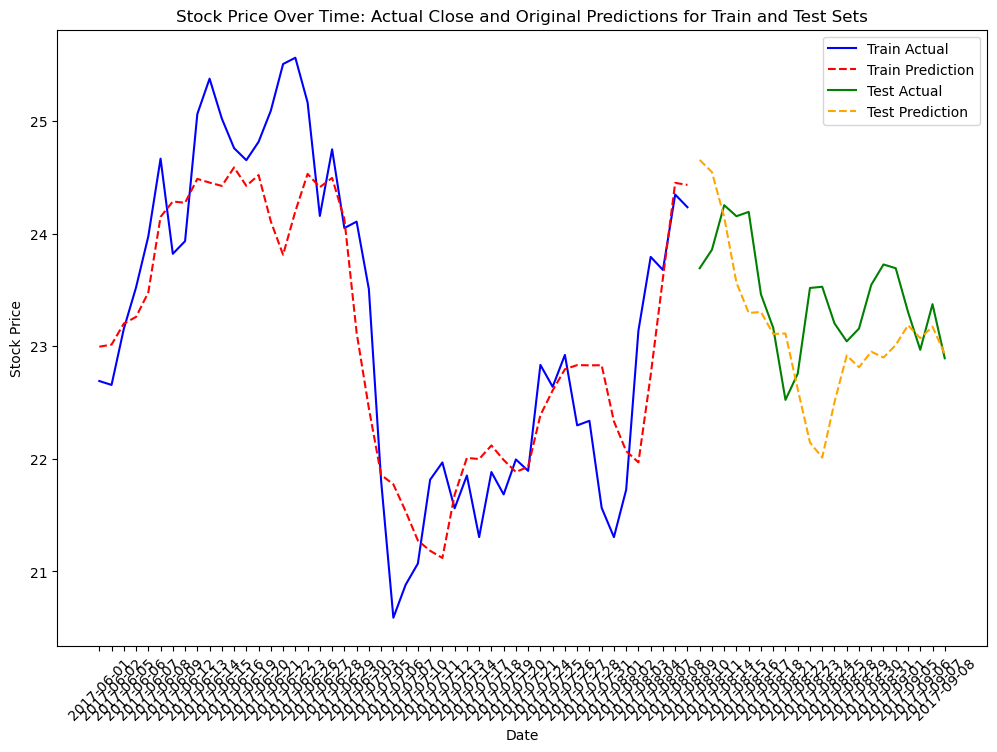

In [ ]:
#plotting
plt.figure(figsize=(12, 8))

plt.plot(train_dates, train_close, label='Train Actual', color='blue')
plt.plot(train_dates, CNN_train_predictions, label='Train Prediction', color='red', linestyle='--')
plt.plot(test_dates, test_close, label='Test Actual', color='green')
plt.plot(test_dates, CNN_test_predictions, label='Test Prediction', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Over Time: Actual Close and Original Predictions for Train and Test Sets')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## 3. GRU

In [ ]:
start_time = time.time()

In [ ]:
history3 = GRU_model.fit(x_train, y_train, batch_size = batch_size , epochs=EPOCHS, callbacks = gru_callbacks)

Epoch 1/50


2024-05-06 18:11:41.245567: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - loss: 0.4356 - mae: 0.6210
learning rate for epoch 1 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.3524 - mae: 0.5275 - learning_rate: 0.0100
Epoch 2/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.3629 - mae: 0.5258

2024-05-06 18:11:45.124745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:45.305077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 2 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3041 - mae: 0.4726 - learning_rate: 0.0100
Epoch 3/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1669 - mae: 0.3518
learning rate for epoch 3 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1631 - mae: 0.3424 - learning_rate: 0.0100
Epoch 4/50


2024-05-06 18:11:45.461067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0709 - mae: 0.2131
learning rate for epoch 4 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0756 - mae: 0.2240 - learning_rate: 0.0100
Epoch 5/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0626 - mae: 0.1945
learning rate for epoch 5 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0654 - mae: 0.2074 - learning_rate: 0.0100
Epoch 6/50


2024-05-06 18:11:45.766258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:45.913142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0588 - mae: 0.2067
learning rate for epoch 6 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0592 - mae: 0.1987 - learning_rate: 0.0100
Epoch 7/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0582 - mae: 0.2005
learning rate for epoch 7 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0591 - mae: 0.2043 - learning_rate: 0.0100


2024-05-06 18:11:46.058520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:46.215173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


Epoch 8/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0682 - mae: 0.2010
learning rate for epoch 8 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0702 - mae: 0.2032 - learning_rate: 0.0100
Epoch 9/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0615 - mae: 0.1990
learning rate for epoch 9 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0615 - mae: 0.1940 - learning_rate: 0.0100


2024-05-06 18:11:46.361871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:46.513594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


Epoch 10/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0411 - mae: 0.1687
learning rate for epoch 10 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0463 - mae: 0.1807 - learning_rate: 0.0100
Epoch 11/50


2024-05-06 18:11:46.674627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.0719 - mae: 0.2179
learning rate for epoch 11 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0691 - mae: 0.2124 - learning_rate: 0.0100
Epoch 12/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0781 - mae: 0.2096
learning rate for epoch 12 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0702 - mae: 0.1986 - learning_rate: 0.0100
Epoch 13/50


2024-05-06 18:11:46.979294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:47.125892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0481 - mae: 0.1729
learning rate for epoch 13 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0502 - mae: 0.1727 - learning_rate: 0.0100
Epoch 14/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0589 - mae: 0.2033

2024-05-06 18:11:47.295520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:47.451084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 14 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0556 - mae: 0.1931 - learning_rate: 0.0100
Epoch 15/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0576 - mae: 0.1835
learning rate for epoch 15 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0528 - mae: 0.1761 - learning_rate: 0.0100
Epoch 16/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0526 - mae: 0.1868

2024-05-06 18:11:47.612777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:47.767994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 16 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0449 - mae: 0.1709 - learning_rate: 0.0100
Epoch 17/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0530 - mae: 0.1745
learning rate for epoch 17 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0506 - mae: 0.1731 - learning_rate: 0.0100
Epoch 18/50


2024-05-06 18:11:47.932673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0315 - mae: 0.1376
learning rate for epoch 18 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0340 - mae: 0.1468 - learning_rate: 0.0100
Epoch 19/50


2024-05-06 18:11:48.237282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.0447 - mae: 0.1630
learning rate for epoch 19 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0502 - mae: 0.1728 - learning_rate: 0.0100
Epoch 20/50


2024-05-06 18:11:48.542151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.0341 - mae: 0.1443
learning rate for epoch 20 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0360 - mae: 0.1501 - learning_rate: 0.0100
Epoch 21/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0323 - mae: 0.1421
learning rate for epoch 21 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0456 - mae: 0.1623 - learning_rate: 0.0100
Epoch 22/50


2024-05-06 18:11:48.851413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:49.000248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0366 - mae: 0.1524
learning rate for epoch 22 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0314 - mae: 0.1420 - learning_rate: 0.0100
Epoch 23/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0468 - mae: 0.1721

2024-05-06 18:11:49.154223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:49.301046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 23 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0489 - mae: 0.1721 - learning_rate: 0.0100
Epoch 24/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0399 - mae: 0.1666
learning rate for epoch 24 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0381 - mae: 0.1621 - learning_rate: 0.0100
Epoch 25/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0317 - mae: 0.1339

2024-05-06 18:11:49.606120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:49.769666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 25 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0280 - mae: 0.1286 - learning_rate: 0.0100
Epoch 26/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0278 - mae: 0.1242
learning rate for epoch 26 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0323 - mae: 0.1343 - learning_rate: 0.0100
Epoch 27/50


2024-05-06 18:11:50.088079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0328 - mae: 0.1343
learning rate for epoch 27 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0292 - mae: 0.1303 - learning_rate: 0.0100
Epoch 28/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0278 - mae: 0.1328

2024-05-06 18:11:50.322433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:50.522628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 28 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0285 - mae: 0.1371 - learning_rate: 0.0100
Epoch 29/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0600 - mae: 0.1888
learning rate for epoch 29 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0540 - mae: 0.1789 - learning_rate: 0.0100
Epoch 30/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0307 - mae: 0.1290
learning rate for epoch 30 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0327 - mae: 0.1338 - learning_rate: 0.0100
Epoch 31/50


2024-05-06 18:11:50.830529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:50.978364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0357 - mae: 0.1508
learning rate for epoch 31 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0328 - mae: 0.1440 - learning_rate: 0.0100
Epoch 32/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0447 - mae: 0.1547
learning rate for epoch 32 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0489 - mae: 0.1681 - learning_rate: 0.0100


2024-05-06 18:11:51.134137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:51.284767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


Epoch 33/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0229 - mae: 0.1239
learning rate for epoch 33 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0273 - mae: 0.1300 - learning_rate: 0.0100
Epoch 34/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0319 - mae: 0.1418
learning rate for epoch 34 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0326 - mae: 0.1442 - learning_rate: 0.0100
Epoch 35/50


2024-05-06 18:11:51.448985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:51.603510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0218 - mae: 0.1200
learning rate for epoch 35 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0260 - mae: 0.1277 - learning_rate: 0.0100
Epoch 36/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0237 - mae: 0.1185
learning rate for epoch 36 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0237 - mae: 0.1202 - learning_rate: 0.0100
Epoch 37/50


2024-05-06 18:11:51.750132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:51.899710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.0153 - mae: 0.0989
learning rate for epoch 37 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0180 - mae: 0.1083 - learning_rate: 0.0100
Epoch 38/50


2024-05-06 18:11:52.208783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 0.0354 - mae: 0.1463
learning rate for epoch 38 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0322 - mae: 0.1407 - learning_rate: 0.0100
Epoch 39/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0219 - mae: 0.1162
learning rate for epoch 39 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0191 - mae: 0.1094 - learning_rate: 0.0100


2024-05-06 18:11:52.514210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:52.668815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


Epoch 40/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0264 - mae: 0.1323
learning rate for epoch 40 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0274 - mae: 0.1339 - learning_rate: 0.0100
Epoch 41/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0255 - mae: 0.1235
learning rate for epoch 41 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0263 - mae: 0.1275 - learning_rate: 0.0100
Epoch 42/50


2024-05-06 18:11:52.830687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:52.983680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0209 - mae: 0.1147
learning rate for epoch 42 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0224 - mae: 0.1180 - learning_rate: 0.0100
Epoch 43/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0298 - mae: 0.1344
learning rate for epoch 43 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0317 - mae: 0.1357 - learning_rate: 0.0100


2024-05-06 18:11:53.133869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:53.289811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


Epoch 44/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.0288 - mae: 0.1336
learning rate for epoch 44 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0285 - mae: 0.1304 - learning_rate: 0.0100
Epoch 45/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0381 - mae: 0.1349

2024-05-06 18:11:53.645311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 45 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0333 - mae: 0.1292 - learning_rate: 0.0100
Epoch 46/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0301 - mae: 0.1284

2024-05-06 18:11:53.847761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:54.038172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 46 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0288 - mae: 0.1264 - learning_rate: 0.0100
Epoch 47/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0264 - mae: 0.1294
learning rate for epoch 47 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0280 - mae: 0.1345 - learning_rate: 0.0100
Epoch 48/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0244 - mae: 0.1172

2024-05-06 18:11:54.208830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:54.366561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 48 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0285 - mae: 0.1269 - learning_rate: 0.0100
Epoch 49/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0368 - mae: 0.1535
learning rate for epoch 49 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0322 - mae: 0.1426 - learning_rate: 0.0100
Epoch 50/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0195 - mae: 0.1134

2024-05-06 18:11:54.527131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-05-06 18:11:54.689445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



learning rate for epoch 50 is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0201 - mae: 0.1169 - learning_rate: 0.0100


In [ ]:
end_time = time.time()

GRU_training_time = end_time - start_time
print("Training time:", GRU_training_time, "seconds")

Training time: 13.692819833755493 seconds


In [ ]:
GRU_loss, GRU_mae = GRU_model.evaluate(x_test, y_test)
print('Eval loss: {}, Eval mean absolute error: {}'.format(GRU_loss, GRU_mae))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0056 - mae: 0.0588
Eval loss: 0.005616033915430307, Eval mean absolute error: 0.05879257246851921


2024-05-06 18:11:56.154684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


In [ ]:
start_time = time.time()
GRU_train_predictions= GRU_model.predict(x_train)
GRU_test_predictions = GRU_model.predict(x_test)
end_time = time.time()
GRU_prediction_time = end_time - start_time
print("Prediction time:", GRU_prediction_time,"seconds")

train_data = list(zip(GRU_train_predictions, train_df.select("Date").collect()))
test_data = list(zip(GRU_test_predictions, test_df.select("Date").collect()))
GRU_train_predictions_df = spark.createDataFrame([
    (float(pred[0]), date['Date']) for pred, date in train_data
], ["ScaledPrediction", "Date"])
GRU_test_predictions_df = spark.createDataFrame([
    (float(pred[0]), date['Date']) for pred, date in test_data
], ["ScaledPrediction", "Date"])

1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

2024-05-06 18:11:57.299891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


2024-05-06 18:11:58.325114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


Prediction time: 2.126481056213379 seconds


24/05/06 18:11:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:11:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:11:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:11:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:12:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:12:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

In [ ]:
GRU_train_predictions_df.show()
GRU_test_predictions_df.show()

+-------------------+----------+
|   ScaledPrediction|      Date|
+-------------------+----------+
| 0.9504129886627197|2017-06-22|
| 0.3996080160140991|2017-08-02|
|  0.724747896194458|2017-06-07|
| 0.6695845127105713|2017-08-07|
| 0.7500399351119995|2017-06-29|
| 0.8199596405029297|2017-06-19|
| 0.6183949708938599|2017-08-03|
|0.27640867233276367|2017-07-06|
| 0.9586596488952637|2017-06-23|
| 0.8233283758163452|2017-06-28|
| 0.6826088428497314|2017-06-12|
| 0.7339009046554565|2017-06-30|
| 0.8860735893249512|2017-06-26|
| 0.7308177947998047|2017-08-04|
| 0.7586604952812195|2017-08-08|
|0.41488727927207947|2017-07-14|
| 0.6787190437316895|2017-06-06|
| 0.6952936053276062|2017-06-09|
| 0.6429917812347412|2017-07-03|
|  0.449667751789093|2017-07-12|
+-------------------+----------+
only showing top 20 rows

+------------------+----------+
|  ScaledPrediction|      Date|
+------------------+----------+
|0.6075706481933594|2017-08-18|
| 0.667394757270813|2017-08-10|
|0.5669807195663452|20

In [ ]:
def inverse_transform_scaled_predictions(predictions_df, scaler_model, scaled_col="ScaledPrediction", original_col="OriginalPrediction"):

    original_min = scaler_model.originalMin.toArray()[0]
    original_max = scaler_model.originalMax.toArray()[0]
    range_val = original_max - original_min
    restored_df = predictions_df.withColumn(
        original_col,
        expr(f"{original_min} + {range_val} * {scaled_col}")
    )

    return restored_df.select(original_col, scaled_col)

original_train_predictions_df = inverse_transform_scaled_predictions(GRU_train_predictions_df, scalerModel)
original_train_predictions_df.show()

+------------------+-------------------+
|OriginalPrediction|   ScaledPrediction|
+------------------+-------------------+
| 25.27245604685686| 0.9504129886627197|
|  22.0414334553584| 0.3996080160140991|
| 23.94870435962821|  0.724747896194458|
|23.625115889823974| 0.6695845127105713|
|24.097067488477023| 0.7500399351119995|
|24.507216559250082| 0.8199596405029297|
|23.324837979726453| 0.6183949708938599|
|  21.3187459662131|0.27640867233276367|
|25.320830965092682| 0.9586596488952637|
|24.526977564402387| 0.8233283758163452|
|23.701516625126715| 0.6826088428497314|
| 24.00239591759555| 0.7339009046554565|
| 24.89504105769265| 0.8860735893249512|
|   23.984310391701| 0.7308177947998047|
|24.147635704163577| 0.7586604952812195|
|  22.1310616308823|0.41488727927207947|
|23.678699059108112| 0.6787190437316895|
|23.775925456144932| 0.6952936053276062|
| 23.46912289695956| 0.6429917812347412|
|22.335083921939486|  0.449667751789093|
+------------------+-------------------+
only showing top

In [ ]:
def inverse_transform_scaled_predictions(predictions_df, scaler_model, scaled_col="ScaledPrediction", original_col="OriginalPrediction"):
    original_min = scaler_model.originalMin.toArray()[0]
    original_max = scaler_model.originalMax.toArray()[0]
    range_val = original_max - original_min
    restored_df = predictions_df.withColumn(
        original_col,
        expr(f"{original_min} + {range_val} * {scaled_col}")
    )
    return restored_df.select(predictions_df["Date"], original_col, scaled_col)

GRU_train_predictions_df = inverse_transform_scaled_predictions(GRU_train_predictions_df, scalerModel)
GRU_test_predictions_df = inverse_transform_scaled_predictions(GRU_test_predictions_df, scalerModel)
GRU_train_predictions_df.show()
GRU_test_predictions_df.show()

+----------+------------------+-------------------+
|      Date|OriginalPrediction|   ScaledPrediction|
+----------+------------------+-------------------+
|2017-06-22| 25.27245604685686| 0.9504129886627197|
|2017-08-02|  22.0414334553584| 0.3996080160140991|
|2017-06-07| 23.94870435962821|  0.724747896194458|
|2017-08-07|23.625115889823974| 0.6695845127105713|
|2017-06-29|24.097067488477023| 0.7500399351119995|
|2017-06-19|24.507216559250082| 0.8199596405029297|
|2017-08-03|23.324837979726453| 0.6183949708938599|
|2017-07-06|  21.3187459662131|0.27640867233276367|
|2017-06-23|25.320830965092682| 0.9586596488952637|
|2017-06-28|24.526977564402387| 0.8233283758163452|
|2017-06-12|23.701516625126715| 0.6826088428497314|
|2017-06-30| 24.00239591759555| 0.7339009046554565|
|2017-06-26| 24.89504105769265| 0.8860735893249512|
|2017-08-04|   23.984310391701| 0.7308177947998047|
|2017-08-08|24.147635704163577| 0.7586604952812195|
|2017-07-14|  22.1310616308823|0.41488727927207947|
|2017-06-06|

In [ ]:
GRU_train_result_df = create_prediction_dataframe(scaled_df, GRU_train_predictions_df, scalerModel)
GRU_train_result_df.show()
GRU_test_result_df = create_prediction_dataframe(scaled_df, GRU_test_predictions_df, scalerModel)
GRU_test_result_df.show()

24/05/06 18:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

+----------+------------------+------------------+
|      Date|             Close|OriginalPrediction|
+----------+------------------+------------------+
|2017-06-22|25.507333755493164| 25.27245604685686|
|2017-08-02| 21.72599983215332|  22.0414334553584|
|2017-06-07|23.976667404174805| 23.94870435962821|
|2017-08-07| 23.67799949645996|23.625115889823974|
|2017-06-29|24.049999237060547|24.097067488477023|
|2017-06-19| 24.65333366394043|24.507216559250082|
|2017-08-03|23.139333724975586|23.324837979726453|
|2017-07-06|20.588666915893555|  21.3187459662131|
|2017-06-23| 25.56333351135254|25.320830965092682|
|2017-06-28|24.749332427978516|24.526977564402387|
|2017-06-12| 23.93400001525879|23.701516625126715|
|2017-06-30|24.107332229614258| 24.00239591759555|
|2017-06-26|25.166000366210938| 24.89504105769265|
|2017-08-04| 23.79400062561035|   23.984310391701|
|2017-08-08|24.347999572753906|24.147635704163577|
|2017-07-14|21.851999282836914|  22.1310616308823|
|2017-06-06|23.523332595825195|

24/05/06 18:14:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:14:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:14:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:14:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:14:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:14:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

+----------+------------------+------------------+
|      Date|             Close|OriginalPrediction|
+----------+------------------+------------------+
|2017-08-18|23.163999557495117| 23.26134249054303|
|2017-08-10| 23.69333267211914| 23.61227078194179|
|2017-09-06|22.968666076660156| 23.02324192338483|
|2017-08-31|23.726667404174805|23.761541928243105|
|2017-08-22| 22.75666618347168| 22.87914371439956|
|2017-09-01| 23.69333267211914| 23.67042061119787|
|2017-08-14|24.253332138061523|24.240018175984005|
|2017-08-23| 23.51799964904785|23.624280947322404|
|2017-08-16|24.194000244140625|24.041317944092498|
|2017-08-25|23.203332901000977|23.189193388749118|
|2017-08-15|24.155332565307617|24.105602572817816|
|2017-09-08|22.893333435058594|23.081656430812473|
|2017-09-05|23.305999755859375|23.322616361361725|
|2017-08-29|23.157333374023438|  23.2646382057942|
|2017-08-17|23.461332321166992|23.416198101515647|
|2017-08-30|23.545333862304688|23.649443904589134|
|2017-08-28| 23.04400062561035|

In [ ]:
#sorting by date
GRU_train_result_df = GRU_train_result_df.orderBy("Date")
GRU_test_result_df = GRU_test_result_df.orderBy("Date")

In [ ]:
train_data = GRU_train_result_df.select("Date", "Close", "OriginalPrediction").collect()
train_dates = [row["Date"] for row in train_data]
train_close = [row["Close"] for row in train_data]
GRU_train_predictions = [row["OriginalPrediction"] for row in train_data]

test_data = GRU_test_result_df.select("Date", "Close", "OriginalPrediction").collect()
test_dates = [row["Date"] for row in test_data]
test_close = [row["Close"] for row in test_data]
GRU_test_predictions = [row["OriginalPrediction"] for row in test_data]

24/05/06 18:15:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:15:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:15:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:15:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:15:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 18:15:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/06 1

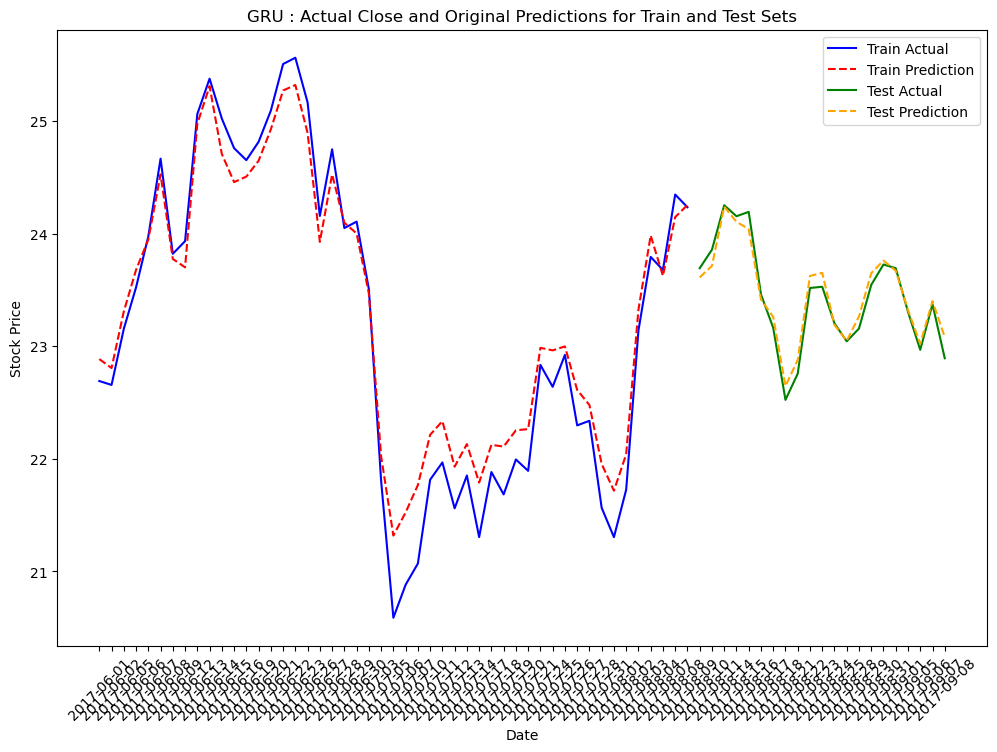

In [ ]:
#plotting
plt.figure(figsize=(12, 8))

plt.plot(train_dates, train_close, label='Train Actual', color='blue')
plt.plot(train_dates, GRU_train_predictions, label='Train Prediction', color='red', linestyle='--')
plt.plot(test_dates, test_close, label='Test Actual', color='green')
plt.plot(test_dates, GRU_test_predictions, label='Test Prediction', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('GRU : Actual Close and Original Predictions for Train and Test Sets')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### MAE over Epochs


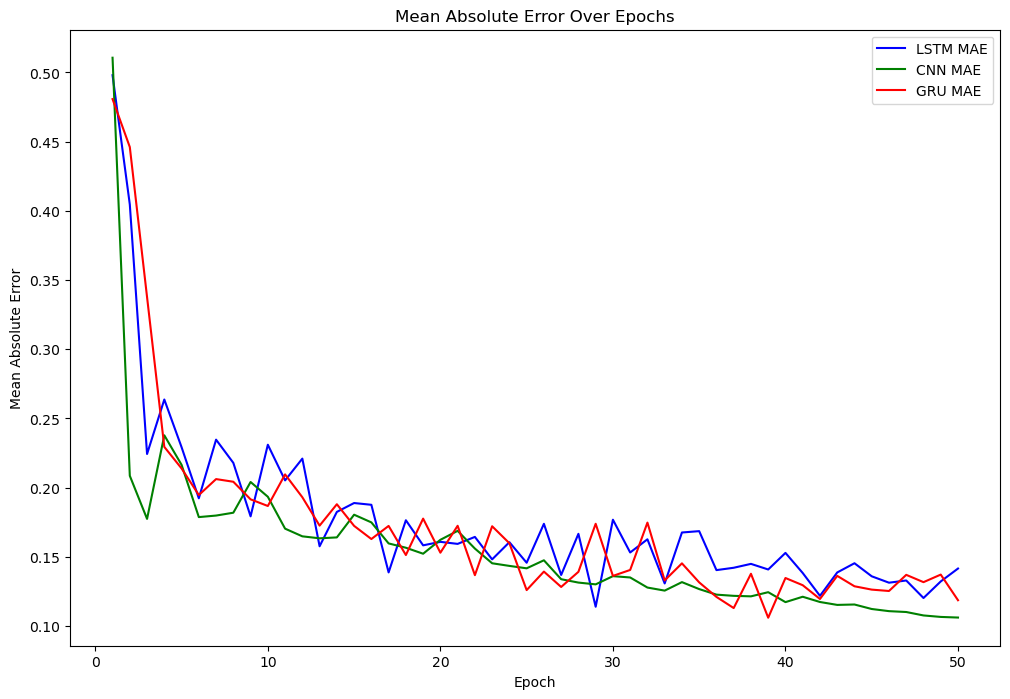

In [ ]:
#mae
mae_history_LSTM = history1.history['mae']
mae_history_CNN = history2.history['mae']
mae_history_GRU = history3.history['mae']

#plotting all maes
plt.figure(figsize=(12, 8))
plt.plot(range(1, EPOCHS + 1), mae_history_LSTM, label='LSTM MAE', color='blue')
plt.plot(range(1, EPOCHS + 1), mae_history_CNN, label='CNN MAE', color='green')
plt.plot(range(1, EPOCHS + 1), mae_history_GRU, label='GRU MAE', color='red')

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error Over Epochs')
plt.legend()

plt.show()

### Loss over Epochs

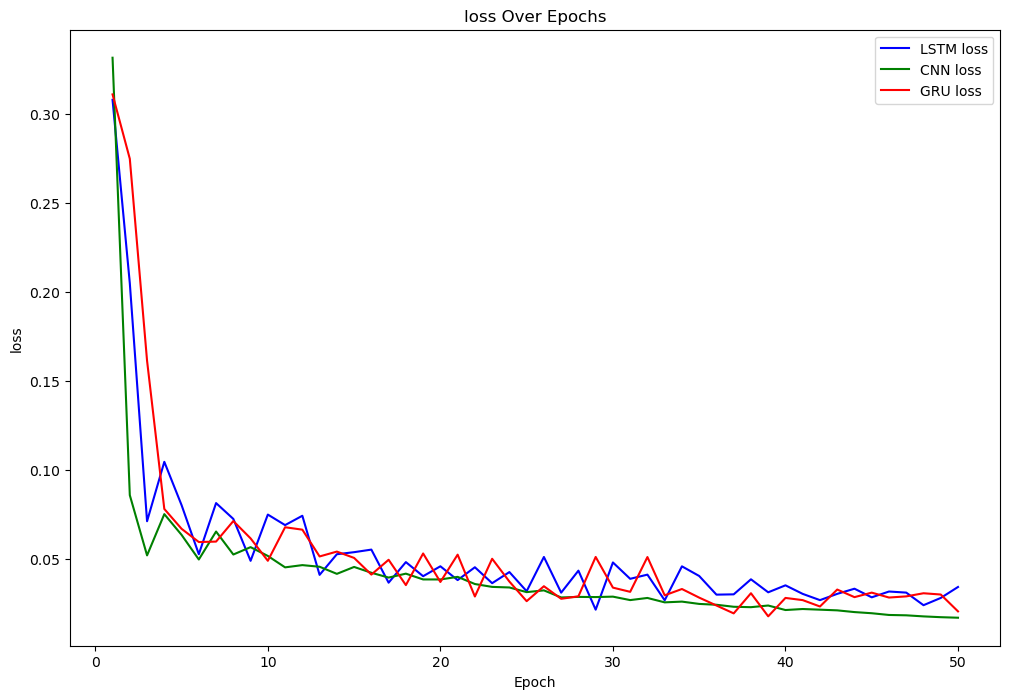

In [ ]:
#loss
loss_history_LSTM = history1.history['loss']
loss_history_CNN = history2.history['loss']
loss_history_GRU = history3.history['loss']

#plotting all loss
plt.figure(figsize=(12, 8))

plt.plot(range(1, EPOCHS + 1), loss_history_LSTM, label='LSTM loss', color='blue')
plt.plot(range(1, EPOCHS + 1), loss_history_CNN, label='CNN loss', color='green')
plt.plot(range(1, EPOCHS + 1), loss_history_GRU, label='GRU loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('loss Over Epochs')
plt.legend()
plt.show()

## Ensemble Model

In [ ]:
#creating ensemble model
lstm_predictions = LSTM_model.predict(x_test)
cnn_predictions = CNN_model.predict(x_test)
gru_predictions = GRU_model.predict(x_test)

ensemble_input = np.concatenate([lstm_predictions, cnn_predictions, gru_predictions], axis=1)
ensemble_model = Sequential(name="Ensemble_model")
ensemble_model.add(Dense(1, input_shape=(3,)))  # Output layer for regression, input_shape is (number of models,)
ensemble_model.compile(optimizer='adam', loss='mean_squared_error')
ensemble_loss = ensemble_model.evaluate(ensemble_input, y_test)

print("Ensemble Model Loss:", ensemble_loss)

2024-05-06 18:17:15.188842: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-05-06 18:17:15.227347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


2024-05-06 18:17:15.596845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


2024-05-06 18:17:16.041334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step - loss: 0.0182
Ensemble Model Loss: 0.01822543889284134


In [ ]:
Computation_time= [
    ("DT", dt_training_time, dt_prediction_time),
    ("LSTM", LSTM_training_time, LSTM_prediction_time),
    ("CNN", CNN_training_time, CNN_prediction_time),
    ("GRU", GRU_training_time, GRU_prediction_time)
]

time_df = spark.createDataFrame(Computation_time, ["Model", "Training Time", "Prediction Time"])
time_df.show()

+-----+------------------+-------------------+
|Model|     Training Time|    Prediction Time|
+-----+------------------+-------------------+
|   DT| 73.33275175094604|0.16225218772888184|
| LSTM|11.695804119110107| 1.0257866382598877|
|  CNN|  9.10417127609253| 0.4759659767150879|
|  GRU|13.692819833755493|  2.126481056213379|
+-----+------------------+-------------------+



In [ ]:
Eval = [
    ("DL", dt_mae, dt_loss),
    ("LSTM", LSTM_mae, LSTM_loss),
    ("CNN", CNN_mae, CNN_loss),
    ("GRU", GRU_mae, GRU_loss)
]

Eval = spark.createDataFrame(Eval, ["Model", "MAE", "Loss"])
Eval.show()


+-----+-------------------+--------------------+
|Model|                MAE|                Loss|
+-----+-------------------+--------------------+
|   DL|0.15026869880560725| 0.03460707986101471|
| LSTM|0.07801785320043564|0.010592230595648289|
|  CNN|0.09694807976484299|0.013736503198742867|
|  GRU|0.05879257246851921|0.005616033915430307|
+-----+-------------------+--------------------+

